In [ ]:
import OffsetArrays
using Plots
using Revise
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
using IterTools
using DelimitedFiles
include("./src/functions.jl")

# Population dynamics for the messages

In [2]:
Threads.nthreads()

7

In [3]:
# S=0   I=1
# The times go from ti = 0 to ti=T+1
# when ti=0 it means that i is the zero patient
# when ti=T+1 it means that i is never infected
degreetype = "regular"
d = 3 # degree 
T = 8 # discrete time
N = 1000; #population size
γ = 0.15
λ = 0.15
grid = 21
frRange = LinRange(0.0,1.0,grid) # planted autoinfection probability
dilRange = LinRange(0.0,1.0,grid) # planted infection rate

#folderstring = "./results/T=$(T)_d=$(d)_min=$(γvalues[1])_max=$(γvalues[end])_fr=$(fr)_dil=$(dil)/"

21-element LinRange{Float64, Int64}:
 0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,…,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0

In [4]:
function Dil_vs_FR(γ, λ, N, T, dist, paramdist, frRange , dilRange ; tot_iterations = 2 )
    inf_out = zeros(length(frRange),length(dilRange), T + 2) # 1 value for pdiag and T+1 values for the AUC
    pr = Progress(length(frRange) * length(dilRange))
    Threads.@threads for (frcount,dilcount) in collect(product(1:length(frRange),1:length(dilRange)))
        λi = λp = λ
        γi = γp = γ
        fr = frRange[frcount]
        dilution = dilRange[dilcount]
        marg = pop_dynamics(N, T, λp, λi, γp, γi, dist, paramdist, tot_iterations = tot_iterations, fr=fr, dilution=dilution)
        marg2D = reshape((sum(marg,dims=1)./ N),T+2,T+2);
        # we sum over the trace of the 2D marginal to find the probability to infere correctly
        inf_out[frcount,dilcount,1] = sum([marg2D[t,t] for t=1:T+2])
        inf_out[frcount,dilcount,2:end] .= avgAUC(marg)
        ProgressMeter.next!(pr)
    end
    return inf_out
end


Dil_vs_FR (generic function with 1 method)

In [ ]:
miao = Dil_vs_FR(γ, λ, N, T, degreetype, d, frRange , dilRange ; tot_iterations = 10 )
open("./results/diag.txt","w") do io
    writedlm(io,miao[:,:,1]) 
end
for t = 1:T+1
    open("./results/AUC$(t).txt","w") do io
        writedlm(io,miao[:,:,t+1]) 
    end
end

Progress:  32%|█████████████▎                           |  ETA: 0:42:17

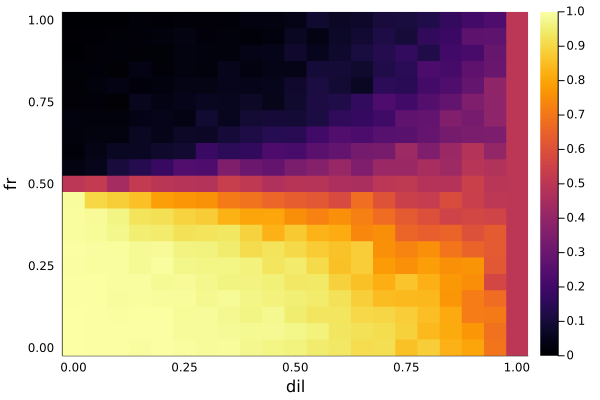

In [13]:
heatmap(dilRange,frRange,miao[:,:,end],ylabel="fr",xlabel="dil")